<a href="https://colab.research.google.com/github/athankefalas/TrafficCongestionSNA/blob/master/ICM%26TwoStep/ICM%26TwoStep%26Heuristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from operator import add 

In [206]:
#download graph from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#make sure to provide the correct path for every graph
file1 = '/content/drive/My Drive/SNA/Data/ia-email-univ/ia-email-univ.mtx' #google drive path
file2 = '/content/drive/My Drive/SNA/Data/ia-fb-messages/ia-fb-messages.mtx'
file3 = '/content/drive/My Drive/SNA/Data/ia-email-EU/ia-email-EU.mtx'
file=file3
g = nx.readwrite.read_adjlist(file,comments="%")

In [208]:
#number of nodes
nodes = len(g.nodes())
print("The number of nodes is",nodes)
#number of edges
edges = len(g.edges())
print("The number of edges is", edges)
#max_degree
max_degree=max(dict(g.degree()).items(), key = lambda x : x[1])[1]
print("The maximum degree is:", max_degree)



The number of nodes is 32431
The number of edges is 54399
The maximum degree is: 623


In [0]:
#g.edges()

In [0]:
if not g.is_directed():
    g = g.to_directed()

In [194]:
#top five nodes with the highest degree centrality
degree_centrality=nx.degree_centrality(g)
sorted_degree_centrality=sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_degree_centrality_nodes=[i[0] for i in sorted_degree_centrality]
print("The five nodes with the highest degree centrality scores are: ", top_degree_centrality_nodes)



The five nodes with the highest degree centrality scores are:  ['105', '333', '16', '23', '42']


In [0]:
# #top five nodes with the highest closeness centrality
# closeness_centrality=nx.closeness_centrality(g)
# sorted_closeness_centrality=sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
# top_closeness_centrality_nodes=[i[0] for i in sorted_closeness_centrality]
# print("The five nodes with the highest closeness centrality scores are: ", top_closeness_centrality_nodes)

# #top five nodes with the highest betweenness centrality
# betweenness_centrality=nx.betweenness_centrality(g)
# sorted_betweenness_centrality=sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
# top_betweenness_centrality_nodes=[i[0] for i in sorted_betweenness_centrality]
# print("The five nodes with the highest betweenness centrality scores are: ", top_betweenness_centrality_nodes)

In [0]:
# #nodes with the highest pagerank
# pageranked = nx.pagerank(g, alpha=0.85)
# sorted_pageranked = sorted(pageranked.items(), key=lambda x: x[1], reverse=True)[:5]
# top_pageranked_nodes = [i[0] for i in sorted_pageranked]
# print("The five nodes with the highest PageRank scores are: ", top_pageranked_nodes)

# #nodes with the highest hub scores(HITS Algorithm)
# hubscore = nx.hits(g)
# sorted_hubscore = sorted(hubscore[0].items(), key=lambda x: x[1], reverse=True)[:5]
# top_hubscore_nodes = [i[0] for i in sorted_hubscore]
# print("The five nodes with the highest hub scores are: ", top_hubscore_nodes)

# #nodes with the highest authority scores(HITS Algorithm)
# authorityscore = nx.hits(g)
# sorted_authorityscore = sorted(authorityscore[1].items(), key=lambda x: x[1], reverse=True)[:5]
# top_authorityscore_nodes = [i[0] for i in sorted_authorityscore]
# print("The five nodes with the highest authority scores are: ", top_authorityscore_nodes)

In [0]:
#FUNCTION to set activation RANDOM probabilities 
def set_activation_probabilities(G):
  attr={}
  for edge in G.edges():
    attr.update( {edge : np.random.uniform(0.0, 0.1)})
                                                 
  nx.set_edge_attributes(G, attr, 'prob')
  
  return G

In [0]:
g=set_activation_probabilities(g)

In [0]:
#FUNCTION for each iteration of diffusion process 
def diffusion_process(Graph,Seed,Visited):
  iter_activations = set()   #this iteration's activations
  iter_visits = set()        #this iteration's visits
  for s in Seed:
    for n in Graph.successors(s):  #successor of n is a node m such that there exists a directed edge from n to m
      if (s, n) in Visited or (s, n) in iter_visits or  n in Seed:   #check if successor was visited before, or seed tried before
        continue
      
      diffusion_prob = g[s][n]['prob']
      activation_prob = np.random.uniform(0.0, 1.0)
      activation = activation_prob >= (1.0-diffusion_prob)
      
      if activation:               
        iter_activations.add(n)

      iter_visits.add((s, n))

  iter_activations = list(iter_activations)
  Seed.extend(iter_activations)
  return Seed, iter_activations, iter_visits

In [0]:
#FUNCTION for ICM and two step ICM 
def ICM(g,start_seeds,num_iter,multi_step=False,step_iter=0):
  visited_edges = set() 
  activated_nodes = []
  num_nodes=[]
  
  
  if multi_step==True:  #split the seed nodes to 2 groups for two step
    
    multi_seeds=start_seeds[len(start_seeds)//2:]
    seeds=start_seeds[0:len(start_seeds)//2]
       
  else:
    seeds=start_seeds
      
  len_seeds=len(seeds)
    
  for s in seeds:
    activated_nodes.append(s)
  num_nodes.append(len_seeds)
  
  while True:
    len_seeds=len(seeds)
    
    if multi_step==True and num_iter==step_iter: #activate multi_seeds
      for s in multi_seeds:
        seeds.append(s)
      
    seeds, iter_activations, iter_visits = diffusion_process(g, seeds, visited_edges)
    
    num_nodes.append(len(iter_activations))
    
    for i in iter_activations:
      activated_nodes.append(i)
    visited_edges = visited_edges.union(iter_visits)
    
    if len(seeds) == len_seeds:
      break
    len_seeds=len(seeds)
    num_iter-= 1
    if not num_iter or len(seeds) >= len(g):
      break

  return activated_nodes,num_nodes

In [201]:
#simple ICM

affected_avg1 = 0.0
#how many times the diffusion will happen with the same seeds
count1=3
#number of iterations 
num_iter1=20
avg_activations1=[]
for n in range(0, count1):
    #create seed nodes
    seeds1=top_degree_centrality_nodes[:5] 
    
    num_iter1=20
    if n==0:
      print('Diffusion model : ICM')
      print('Starting diffusion for', num_iter1,'iterations, with starting seed nodes:',seeds1)
    
    affected1,activations1 = ICM(g,seeds1,num_iter1)
    
    affected_avg1 += len(affected1)
    
    if len(avg_activations1)<len(list(activations1)):
      ext=len(list(activations1))- len(avg_activations1)
      avg_activations1.extend([0]*ext)

    avg_activations1 = list(map(add, avg_activations1, activations1))
    

act_n1=affected_avg1 / count1
act_per_iter1=[x//(count1) for x in avg_activations1]
while act_per_iter1[-1] == 0:
        act_per_iter1.pop() 
print("Average nodes activated:",int(act_n1))
print("Average activations per iteration",act_per_iter1)



Diffusion model : ICM
Starting diffusion for 20 iterations, with starting seed nodes: ['105', '333', '16', '23', '42']
Average nodes activated: 76
Average activations per iteration [5, 12, 12, 8, 7, 8, 9, 8, 2, 1]


In [202]:
#Two step ICM
step=3
affected_avg2 = 0.0
count2=3
#number of iterations
num_iter2=20
avg_activations2=[0]*20
for n in range(0, count2):
    #create seed nodes
    seeds2=top_degree_centrality_nodes[:5] 
    
    
    if n==0:
      print('Diffusion model : Two step ICM')
      print('Starting diffusion for', num_iter2,'iterations, with seed nodes:',seeds2[len(seeds2)//2:],'and additional seed nodes:',seeds2[0:len(seeds2)//2],'added at',step,'iterations')
    
    affected2,activations2=ICM(g,seeds2,num_iter2,multi_step=True,step_iter=step)
    
    affected_avg2 += len(affected2)
    
    if len(avg_activations2)<len(list(activations2)):
      ext = len(list(activations2)) - len(avg_activations2)
      avg_activations2.extend([0]*ext)

    avg_activations2 = list(map(add, avg_activations2, activations2))
    
  

act_per_iter2=[x//(count2) for x in avg_activations2]
while act_per_iter2[-1] == 0:
        act_per_iter2.pop()
act_n2=affected_avg2 / count2
print("Average nodes activated:",int(act_n2))
print("Indicative activations per iteration",act_per_iter2)


Diffusion model : Two step ICM
Starting diffusion for 20 iterations, with seed nodes: ['16', '23', '42'] and additional seed nodes: ['105', '333'] added at 3 iterations
Average nodes activated: 21
Indicative activations per iteration [2, 4, 3, 2, 2, 1, 1]


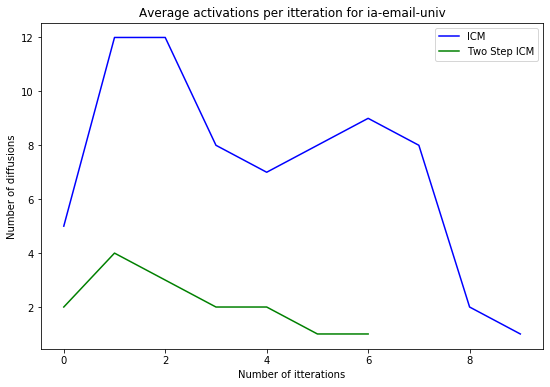

In [203]:
plt.figure(figsize=(9,6))

line_up,=plt.plot(act_per_iter1,'b', label='ICM')
line_down,=plt.plot(act_per_iter2,'g', label='Two Step ICM')
plt.legend(handles=[line_up, line_down])

if file==file1:
  plt.title('Average activations per itteration for ia-email-univ')
elif file==file2:
  plt.title('Average activations per itteration for ia-fb-messages')
elif file==file3:
  plt.title('Average activations per itteration for ia-email-EU')


plt.ylabel('Number of diffusions')
plt.xlabel('Number of itterations')
plt.show()

In [0]:
#uncomment below to plot only ICM
# plt.title('Activations per itteration')
# plt.plot(act_per_iter1)
# plt.ylabel('Number of diffusions')
# plt.xlabel('Number of itterations')
# plt.show()

#uncomment below to plot only ICM two step
# plt.title('Activations per itteration')
# plt.plot(act_per_iter2)
# plt.ylabel('Number of diffusions')
# plt.xlabel('Number of itterations')
# plt.show()